In [1]:
from numpy import *
from numpy.linalg import *
from scipy import signal, stats, io
from scipy.signal import hilbert, resample, detrend
from scipy.stats import ranksums, ttest_ind, entropy, pearsonr, f_oneway
from scipy.io import savemat, loadmat
from scipy.cluster.hierarchy import dendrogram, linkage
from random import *
from itertools import combinations
from pylab import *
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from pyentrp import entropy as ent


from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut

import scipy.io as sio
from scipy.signal import resample

import zlib

import os
import scipy.io as sio
from scipy.signal import resample
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

### Statistical Complexity

In [3]:
def calculate(istring: str, dl: int, sigma: float = 0.05, method: str = "overlapping",
                                     states_provided: bool = False, return_states: bool = False):
    """
    Find the (forwards) Statistical Complexity of an input string for given lambda and sigma values
    """
    #if states are not provided, find them, otherwise declare it
    if(type(states_provided)==bool):
        #first, find all states from the input string and the probabilities of presents
        initial_states = find_states(istring,dl,method=method)
        #next, collapse states which have similar probability distributions
        refined_states = collapse_states(initial_states,dl,sigma)
    else:
        #collapse the states based purely on keynames (already done)
        initial_states,refined_states = states_provided,states_provided
    #convert this into a list of probabilities
    probs = collapse_past(refined_states)
    #create an array of logbase2 probabilities for use in the calculation
    logprobs = np.log2(probs)
    #sum the negative of probability * log2 probability of each state to get the statistical complexity
    complexity = 0.0
    for i in range(len(probs)):
        complexity -= probs[i]*logprobs[i]
    #if states are not desired, only return complexity
    if(return_states==False):
        return complexity
    else:
        return complexity,refined_states,initial_states

def calculate_multi(istrings,dl: int, sigma: float = 0.05):
    """
    Find the (forwards) Statistical Complexity values for an array of strings
    """
    output = []
    for string in istrings:
        output.append(calculate(string,dl,sigma))
    return output

def calculate_bd(istring: str, dl: int, sigma: float = 0.05, method: str ="overlapping",
                              record_states: bool = False):
    """
    Find the forwards, reverse and bidirectional statistical complexity for a string
    """
    #find statistical complexity of forward string and the refined states
    f_sc,f_states,f_states_raw = calculate(istring,dl,sigma,return_states=True,method=method)
    #find complexity of backwards string
    b_sc,b_states,b_states_raw = calculate(istring[::-1],dl,sigma,return_states=True,method=method)
    #collapse the states of forward and reverse complexity based purely on key names
    bd_s = collapse_keys(f_states,b_states)
    #find complexity of bi-directional machine
    bd_sc,bd_states,bd_states_raw = calculate("",dl,sigma,states_provided = bd_s,return_states = True)
    if(record_states==False):
        return f_sc,b_sc,bd_sc
    else:
        return f_sc,b_sc,bd_sc,len(f_states),len(b_states),len(bd_states),len(f_states_raw),len(b_states_raw),len(bd_states_raw)

#Find multiple statistical complexities for forwards, reverse and bidirectional
def calculate_bd_multi(istrings,dl: int, sigma: float = 0.05):
    """
    Find the forwards, reverse and bidirectional Statistical Complexity values for an array of strings
    """
    output = []
    for string in istrings:
        output.append(calculate_bd(string,dl,sigma))
    return output

#input string, desired lambda
def find_states(istring: str, dl: int, method: str = "nonoverlapping"):
    """
    Find the states present in a given input string, outputting the past states, their frequency, and their present state distributions
    """
    #variables used
    i,output_dict = 0,{}
    ## main loop of identifying past and present states
    # Option 1: Non Overlapping
    if(method=="nonoverlapping"):
        while(i+(dl*2)<len(istring)):
            past,present = istring[i:i+dl],istring[i+dl:i+(2*dl)]
            if(past not in output_dict):
                output_dict.update({past: {present:1,"total":1}})
            else:
                if(present not in output_dict[past]):
                    output_dict[past].update({present:1})
                else:
                    output_dict[past][present]+=1
                output_dict[past]["total"]+=1
            i+=dl
    #Option 2: Overlapping
    else:
        while(i+dl+1<len(istring)):
            past,present = istring[i:i+dl],istring[i+1:i+1+dl]
            if(past not in output_dict):
                output_dict.update({past: {present:1,"total":1}})
            else:
                if(present not in output_dict[past]):
                    output_dict[past].update({present:1})
                else:
                    output_dict[past][present]+=1
                output_dict[past]["total"]+=1
            i+=1
    # The last state discovery (main loop misses the final state that can be found)
    try:
        if(method=="nonoverlapping"):
            past,present = istring[i:i+dl],istring[i+dl:i+(2*dl)]
        else:
            past,present = istring[i:i+dl],istring[i+1:i+1+dl]
        if(past not in output_dict):
            output_dict.update({past: {present:1,"total":1}})
        else:
            if(present not in output_dict[past]):
                output_dict[past].update({present:1})
            else:
                output_dict[past][present]+=1
            output_dict[past]["total"]+=1
    except:
        pass
    #collapse counts into probabilities with total counts
    for past in output_dict:
        for present in output_dict[past]:
            if(present!="total"):
                output_dict[past][present]/=output_dict[past]["total"]
    return output_dict

def collapse_states(odict: dict, dl: int, sigma: float = 0.1):
    """
    Collapse a dictionary of state counts into practical states based on a permitted difference sigma
    """
    # Newdict is the collapsed dictionary, temp is used to override newdict when necessary,
    # done_checker is a dictionary used to record the keys already compared
    newdict,temp,done_checker = deepcopy(odict),False,{}
    while(True):
        # If temp is not a boolean, i.e. it's become a dictionary, override newdict
        if(type(temp)!=bool):
            newdict = deepcopy(temp)
            temp = False
        for past1 in newdict:
            if(past1 not in done_checker):
                done_checker[past1] = {}
            for past2 in newdict:
                if(past1!=past2):
                    if(past2 not in done_checker[past1]):
                        done_checker[past1][past2] = True
                    else:
                        # If these states have already been checked, don't bother checking them again
                        continue
                    # If the difference is less than sigma, merge these states and break the past2 loop
                    if(calculate_difference(newdict[past1],newdict[past2])<sigma):
                        temp = merge_states(newdict,past1,past2,dl)
                        break
            # If the dictionary must be updated, break the past1 loop
            if(type(temp)!=bool):
                break
        # If temp is still a boolean, i.e. there was no merging of states in this loop, break the main loop
        if(type(temp)==bool):
            break
    return newdict

def calculate_difference(past1: dict, past2: dict):
    """
    Calculate the difference between two past states' present state distributions
    """
    difference = -np.inf
    # Cycle through past 1 and check for max differences
    for present in past1:
        # Ensure this check isn't being performed on the total state count
        if(present!="total"):
            if(present not in past2):
                difference = max(difference,past1[present])
            else:
                difference = max(difference,abs(past1[present]-past2[present]))
    # Cycle through past 2
    for present in past2:
        if(present!="total"):
            if(present not in past1):
                difference = max(difference,past2[present])
    return difference

def merge_states(odict: dict, past1: dict, past2: dict, dl: int):
    """
    Merge 2 states and their present state distributions, creating a new state key in a standardised manner
    """
    nprobs = {}
    for present in odict[past1]:
        if(present in odict[past2]):
            nprobs.update({present:(odict[past1][present]+odict[past2][present])/2})
        else:
            nprobs.update({present:odict[past1][present]/2})
    for present in odict[past2]:
        if(present not in odict[past1]):
            nprobs.update({present:odict[past2][present]/2})
    nprobs.update({"total":odict[past1]["total"]+odict[past2]["total"]})
    #create a sorted version of the two pasts combined
    temp,to_sort = past1+past2,[]
    for i in range(int(len(temp)/dl)):
        to_sort.append(temp[(i*dl):(i*dl)+dl])
    newkey = ""
    while(len(to_sort)>0):
        newkey += to_sort.pop(to_sort.index(min(to_sort)))
    #add the new key and remove the old ones
    ndict = deepcopy(odict)
    ndict.update({newkey:nprobs})
    del ndict[past1]
    del ndict[past2]
    return ndict

#collapse dictionary of past states and future states into an array of probabilities of the past states
def collapse_past(odict):
    """
    Collapse a dictionary of past states with present state distribtuions into an array of probabilities of the past states
    """
    probs,i,total = np.zeros(len(odict),dtype=float),0,0
    for past in odict:
        probs[i] += odict[past]["total"]
        total += odict[past]["total"]
        i+=1
    return probs/total

def collapse_keys(d1: dict, d2: dict):
    """
    Merge 2 dictionaries of past states with present state distributions
    Note: keys present in both dictionaries lose their probability distributions and only the "total" key remains,
          but this is all that is needed by the point they are merged
    """
    ndict = {}
    for key in d1:
        # as longer keys are created and sorted in a standard way, they are all standardised
        temp = False
        if(key in d2):
            #if the key is in d2, add the two together and mark this has been done
            ndict.update({key:{"total":d1[key]["total"]+d2[key]["total"]}})
            temp = True
        #if no variant of the key was found in d2, add the key as-is
        if(temp==False):
            ndict.update({key:d1[key]})
    for key in d2:
        if(key not in ndict):
            ndict.update({key:d2[key]})
    return ndict

def probs_to_complexity(probs):
    """
    Calculate the Statistical Complexity given an array of past state probabilities
    """
    #create an array of logbase2 probabilities for use in the calculation
    logprobs = np.log2(probs)
    # Correct any 0-probabilities to become 0 rather than infinity
    for i in range(len(logprobs)):
        if(probs[i]==0): logprobs[i] = 0.
    #sum the negative of probability * log2 probability of each state to get the statistical complexity
    complexity = 0.0
    for i in range(len(probs)):
        complexity -= probs[i]*logprobs[i]
    return complexity

def binarise(data,mode="median"):
    """
    Binarise an array of continuous numbers into an array of 0's and 1's (as a string)
    """
    if(type(data)==list or type(data)==tuple):
        data=np.array(data,dtype=float)
    if(isinstance(data,np.ndarray)==False):
        return "Unusable datatype {}".format(type(data))
    if(mode=="median"):
        threshold=np.median(data)
    elif(mode=="mean"):
        threshold=np.mean(data)
    output = np.zeros([len(data)],dtype=int)
    for i in range(len(data)):
        if(data[i]>=threshold):
            output[i]+=1
    # Convert to string
    outstr = ""
    for element in output:
        outstr += str(element)
    return outstr

def multi_binarise(matrix,mode="median"):
    """
    Binarise a 2D matrix (used for calculating multiple statistical complexities)    
    """
    print("Binarising data...")
    # Convert to numpy matrix
    if(type(matrix)==list or type(matrix)==tuple):
        matrix=np.array(matrix,dtype=object)
    output = []
    percent_check = 0.
    for i in range(len(matrix)):
        output.append(binarise(matrix[i],mode))
        # Output progress
        if((i+1)/float(len(matrix))>=percent_check/100.):
            print("{}% of data binarised".format(\
                round(((i+1)/len(matrix))*100,1)))
            percent_check+=10.
    print("Data Binarised")
    return np.array(output, dtype = object)

### Lempel-Ziv Complexity

In [5]:
'''
Python code to compute LZc complexity measure as described in "Complexity of multi-dimensional spontaneous EEG decreases during propofol induced general anaesthesia"

Author: m.schartner@sussex.ac.uk
Date: 09.12.14

To compute Lempel-Ziv complexity for continuous multidimensional time series X, where rows are time series (minimum 2), and columns are observations, type the following in ipython: 
 
execfile('CompMeasures.py')
LZc(X)
'''

def Pre(X):
 '''
 Detrend and normalize input data, X a multidimensional time series
 '''
 ro,co=shape(X)
 Z=zeros((ro,co))
 for i in range(ro):
  Z[i,:]=signal.detrend(X[i,:]-mean(X[i,:]), axis=0)
 return Z


##########
'''
LZc - Lempel-Ziv Complexity, column-by-column concatenation
'''
##########

def cpr(string):
    """
    Lempel-Ziv-Welch compression of binary input string, e.g., string='0010101'.
    It outputs the size of the dictionary of binary words.
    """
    d = {}
    w = ''
    for c in string:
        wc = w + c
        if wc in d:
            w = wc
        else:
            d[wc] = wc
            w = c
    return len(d)

def LZc_binary(string):
    """
    Compute LZ complexity for a binary string and normalize it using a shuffled result.
    """
    # Shuffling the string
    shuffled_string = list(string)
    np.random.shuffle(shuffled_string)
    shuffled_string = ''.join(shuffled_string)
    
    # Calculate complexities
    original_complexity = cpr(string)
    shuffled_complexity = cpr(shuffled_string)
    
    # Normalize the complexity by the shuffled result if shuffled_complexity is not zero
    if shuffled_complexity != 0:
        normalized_complexity = original_complexity / float(shuffled_complexity)
    else:
        normalized_complexity = original_complexity

    return normalized_complexity


def str_col(X):
    '''
    Input: Continuous multidimensional time series
    Output: One string being the binarized input matrix concatenated column-by-column
    '''
    ro, co = np.shape(X)
    TH = np.zeros(ro)
    M = np.zeros((ro, co))
    for i in range(ro):
        M[i, :] = np.abs(hilbert(X[i, :]))
        TH[i] = np.mean(M[i, :])

    s = ''
    for j in range(co): # replace xrange to range
        for i in range(ro):
            if M[i, j] > TH[i]:
                s += '1'
            else:
                s += '0'

    return s


def LZc(X):
 '''
 Compute LZc and use shuffled result as normalization
 '''
 X=Pre(X)
 SC=str_col(X)
 M=list(SC)
 shuffle(M)
 w=''
 for i in range(len(M)):
  w+=M[i]
 return cpr(SC)/float(cpr(w))

### Import Data

In [7]:
def load_and_downsample(filepath, target_freq=250):
    data = sio.loadmat(filepath)['dat']
    original_freq = 1000  # Hz
    downsample_factor = original_freq // target_freq
    downsampled_data = resample(data, data.shape[1] // downsample_factor, axis=1)
    return downsampled_data

base_path = 'C:/Users/odans/Documents/SUSSEX LAB WORKS/Dissertation Analysis'
participants = ['ba', 'fe', 'fr', 'gi', 'me', 'pa', 'pe', 'te', 'to', 'za']
states = ['E', 'L', 'R', 'W']

def load_all_data(base_path, participants, states, target_freq=250):
    all_data = {}
    for participant in participants:
        all_data[participant] = {}
        participant_path = os.path.join(base_path, participant)
        for state in states:
            filename = f"{state}1000.mat"
            filepath = os.path.join(participant_path, filename)
            downsampled_data = load_and_downsample(filepath, target_freq)
            all_data[participant][state] = downsampled_data
    return all_data

all_data = load_all_data(base_path, participants, states)

### Analysis

In this analysis, the complexity values are normalized to Wakeful Rest (WR). Normalization to Wakeful Rest (WR) is done to ensure that the calculated Statistical Complexity (SC) and Lempel-Ziv Complexity (LZc) values are comparable across different states by accounting for individual baseline differences.

### Implementation

Binarising data...
4.5% of data binarised
13.6% of data binarised
22.7% of data binarised
31.8% of data binarised
40.9% of data binarised
50.0% of data binarised
63.6% of data binarised
72.7% of data binarised
81.8% of data binarised
90.9% of data binarised
100.0% of data binarised
Data Binarised
Binarising data...
4.5% of data binarised
13.6% of data binarised
22.7% of data binarised
31.8% of data binarised
40.9% of data binarised
50.0% of data binarised
63.6% of data binarised
72.7% of data binarised
81.8% of data binarised
90.9% of data binarised
100.0% of data binarised
Data Binarised
Binarising data...
4.5% of data binarised
13.6% of data binarised
22.7% of data binarised
31.8% of data binarised
40.9% of data binarised
50.0% of data binarised
63.6% of data binarised
72.7% of data binarised
81.8% of data binarised
90.9% of data binarised
100.0% of data binarised
Data Binarised
Binarising data...
4.5% of data binarised
13.6% of data binarised
22.7% of data binarised
31.8% of data bi

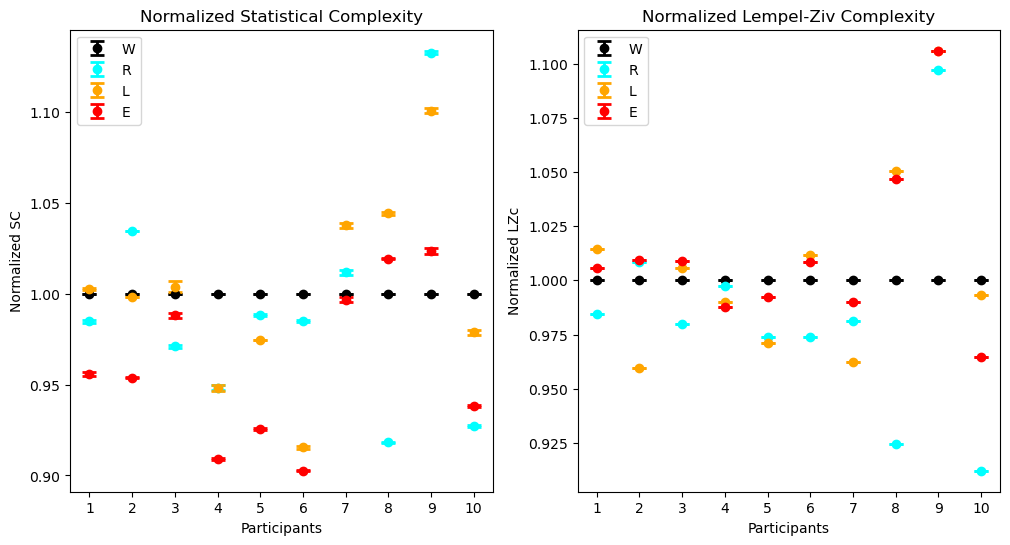

In [10]:
# Step 1: Binarize the data
binarized_data = {}
for participant in participants:
    binarized_data[participant] = {}
    for state in states:
        binarized_data[participant][state] = multi_binarise(all_data[participant][state])

# Step 2: Calculate Statistical Complexity (SC)
sc_values = {}
for participant in participants:
    sc_values[participant] = {}
    for state in states:
        sc_segment_values = calculate_bd_multi(binarized_data[participant][state], dl=3, sigma=0.05)
        if isinstance(sc_segment_values, (list, np.ndarray)) and len(sc_segment_values) > 1:
            sc_values[participant][state] = np.mean(sc_segment_values, axis=0)
        else:
            sc_values[participant][state] = sc_segment_values  # already a scalar

# Step 3: Calculate Lempel-Ziv Complexity (LZc)
lz_values = {}
for participant in participants:
    lz_values[participant] = {}
    for state in states:
        preprocessed_data = Pre(all_data[participant][state])
        lz_segment_values = LZc(preprocessed_data)
        if isinstance(lz_segment_values, (list, np.ndarray)) and len(lz_segment_values) > 1:
            lz_values[participant][state] = np.mean(lz_segment_values, axis=0)
        else:
            lz_values[participant][state] = lz_segment_values  # already a scalar

# Step 4: Normalize to WR
normalized_sc = {}
normalized_lz = {}

for participant in participants:
    normalized_sc[participant] = {}
    normalized_lz[participant] = {}
    
    wr_sc = sc_values[participant]['W']
    wr_lz = lz_values[participant]['W']
    
    for state in states:
        sc_state = sc_values[participant][state]
        lz_state = lz_values[participant][state]
        
        # Perform element-wise division to normalize
        normalized_sc[participant][state] = sc_state / wr_sc
        normalized_lz[participant][state] = lz_state / wr_lz

# Step 5: Plot the Results with Larger Error Bars
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
states_labels = ['W', 'R', 'L', 'E']
state_colors = ['black', 'cyan', 'orange', 'red']

# Parameters for larger error bars
capsize = 5  # Length of the error bar caps
capthick = 2  # Thickness of the error bar caps
elinewidth = 2  # Thickness of the error bar lines

# Plot SC with Larger Error Bars
for i, participant in enumerate(participants):
    for j, state in enumerate(states_labels):
        normalized_sc_mean = np.mean(normalized_sc[participant][state])
        if isinstance(normalized_sc[participant][state], (list, np.ndarray)) and len(normalized_sc[participant][state]) > 1:
            normalized_sc_sem = sem(normalized_sc[participant][state])
        else:
            normalized_sc_sem = 0  # or handle it as np.nan if you prefer

        axes[0].errorbar(i + 1, normalized_sc_mean, yerr=normalized_sc_sem, fmt='o', 
                         color=state_colors[j], capsize=capsize, capthick=capthick, elinewidth=elinewidth)

axes[0].set_title('Normalized Statistical Complexity')
axes[0].set_xlabel('Participants')
axes[0].set_ylabel('Normalized SC')
axes[0].set_xticks(range(1, len(participants) + 1))
axes[0].legend(states_labels)

# Plot LZc with Larger Error Bars
for i, participant in enumerate(participants):
    for j, state in enumerate(states_labels):
        normalized_lz_mean = np.mean(normalized_lz[participant][state])
        if isinstance(normalized_lz[participant][state], (list, np.ndarray)) and len(normalized_lz[participant][state]) > 1:
            normalized_lz_sem = sem(normalized_lz[participant][state])
        else:
            normalized_lz_sem = 0  # or handle it as np.nan if you prefer

        axes[1].errorbar(i + 1, normalized_lz_mean, yerr=normalized_lz_sem, fmt='o', 
                         color=state_colors[j], capsize=capsize, capthick=capthick, elinewidth=elinewidth)

axes[1].set_title('Normalized Lempel-Ziv Complexity')
axes[1].set_xlabel('Participants')
axes[1].set_ylabel('Normalized LZc')
axes[1].set_xticks(range(1, len(participants) + 1))
axes[1].legend(states_labels)

plt.show()

### Correlation Analysis

### 1. General Correlation

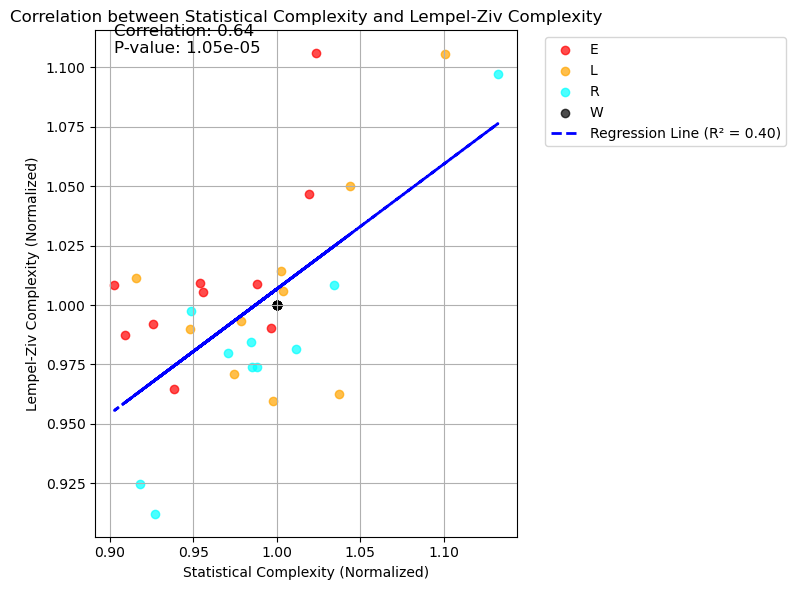

In [14]:
# Step 1: Gather SC and LZc data for all participants and states
sc_all = []
lz_all = []
state_labels = []

for participant in participants:
    for state in states:
        sc_all.append(np.mean(normalized_sc[participant][state]))
        lz_all.append(np.mean(normalized_lz[participant][state]))
        state_labels.append(state)  # Track the state for coloring

# Convert lists to numpy arrays
sc_all = np.array(sc_all)
lz_all = np.array(lz_all)
state_labels = np.array(state_labels)

# Define colors for each state
state_colors = {
    'W': 'black',
    'R': 'cyan',
    'L': 'orange',
    'E': 'red'
}

# Step 2: Calculate the correlation coefficient and regression line
corr_coefficient, p_value = pearsonr(sc_all, lz_all)
slope, intercept, r_value, p_value, std_err = linregress(sc_all, lz_all)

# Step 3: Create Scatter Plot with Colors and Regression Line
plt.figure(figsize=(8, 6))

# Plot each point with its respective state color
for state in states:
    plt.scatter(sc_all[state_labels == state], lz_all[state_labels == state], 
                color=state_colors[state], label=state, alpha=0.7)

# Plot the regression line
plt.plot(sc_all, intercept + slope * sc_all, color='blue', linestyle='--', linewidth=2, label=f'Regression Line (R² = {r_value**2:.2f})')

# Adding titles and labels
plt.title('Correlation between Statistical Complexity and Lempel-Ziv Complexity')
plt.xlabel('Statistical Complexity (Normalized)')
plt.ylabel('Lempel-Ziv Complexity (Normalized)')

# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the correlation coefficient on the plot
plt.text(min(sc_all), max(lz_all), f'Correlation: {corr_coefficient:.2f}\nP-value: {p_value:.2e}', 
         fontsize=12, ha='left')

plt.grid(True)
plt.tight_layout()  # Adjusts the plot to make room for the legend
plt.show()

### 2. State-specific Correlation

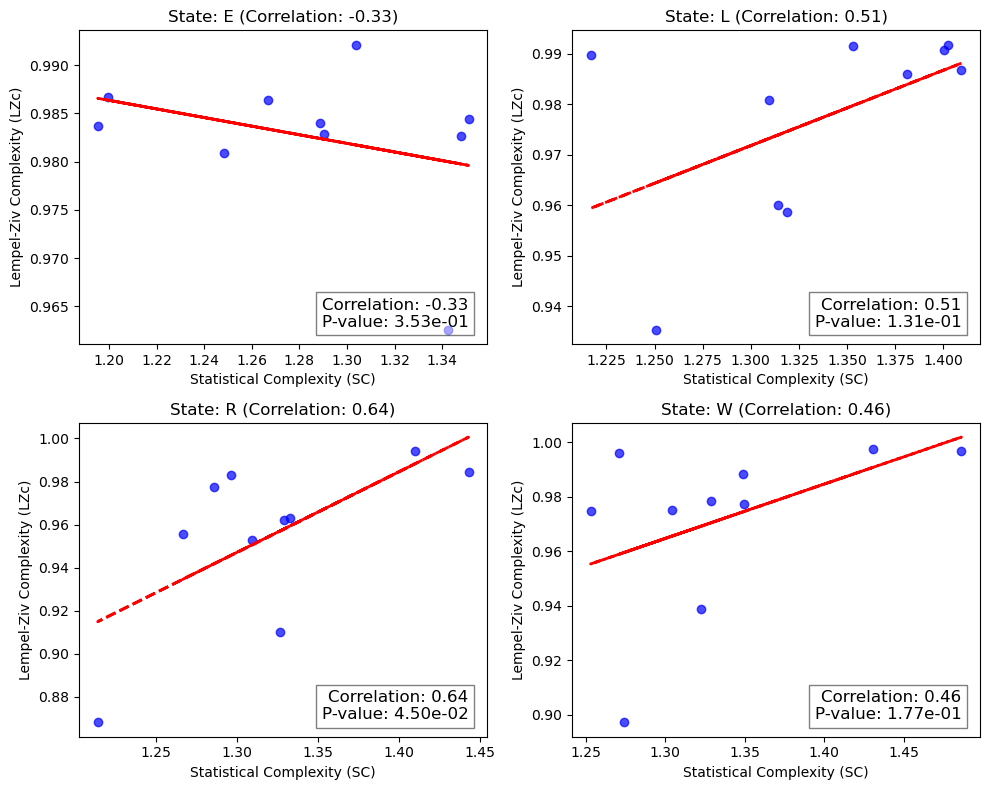

In [16]:
# Gather SC and LZc data for all participants and states (original values, non-normalized)

sc_all = {state: [] for state in states}
lz_all = {state: [] for state in states}

for participant in participants:
    for state in states:
        # Access the dictionary using the participant and state keys
        sc_value = sc_values[participant][state]
        lz_value = lz_values[participant][state]

        # If the values are arrays (e.g., from segments), average them
        if isinstance(sc_value, (np.ndarray, list)):
            sc_value = np.mean(sc_value)
        if isinstance(lz_value, (np.ndarray, list)):
            lz_value = np.mean(lz_value)
        
        sc_all[state].append(sc_value)
        lz_all[state].append(lz_value)

# Step 2: Calculate and plot correlations for each state
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()  # Flatten to easily iterate over subplots

for i, state in enumerate(states):
    sc_values_state = np.array(sc_all[state])
    lz_values_state = np.array(lz_all[state])

    # Calculate the correlation coefficient and regression line
    corr_coefficient, p_value = pearsonr(sc_values_state, lz_values_state)
    slope, intercept, r_value, p_value, std_err = linregress(sc_values_state, lz_values_state)

    # Create Scatter Plot with Colors and Regression Line
    axes[i].scatter(sc_values_state, lz_values_state, color='blue', alpha=0.7)
    axes[i].plot(sc_values_state, intercept + slope * sc_values_state, color='red', linestyle='--', linewidth=2)

    # Adding titles and labels
    axes[i].set_title(f'State: {state} (Correlation: {corr_coefficient:.2f})')
    axes[i].set_xlabel('Statistical Complexity (SC)')
    axes[i].set_ylabel('Lempel-Ziv Complexity (LZc)')

    # Display the correlation coefficient on the lower right of the plot
    axes[i].text(max(sc_values_state), min(lz_values_state), 
                 f'Correlation: {corr_coefficient:.2f}\nP-value: {p_value:.2e}', 
                 fontsize=12, ha='right', va='bottom',
                 bbox=dict(facecolor='white', alpha=0.5))

# Adjust layout
plt.tight_layout()
plt.show()